In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical

C:\Users\Irfan\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("TensorFlow version:", keras.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.10.0
NumPy version: 1.26.0


In [3]:
gRNA_LENGTH = 28
input_length = 33

In [4]:
dct_ohc_seq = {'A': [1, 0, 0, 0],
               'C': [0, 1, 0, 0],
               'G': [0, 0, 1, 0],
               'T': [0, 0, 0, 1],
               'N': [0, 0, 0, 0]}

def seq_one_hot_code(seq):
    seq = seq.upper()
    lst_seq = list(seq)
    return [dct_ohc_seq[i] for i in lst_seq]

In [5]:
file = 'BS6204_input.10WINDOW.csv'
WINDOW_LENGTH_ORIGINAL=10
LENGTH_TO_TEST=3
INPUT_LENGTH=LENGTH_TO_TEST + gRNA_LENGTH + LENGTH_TO_TEST
ACTUAL_LENGTH = WINDOW_LENGTH_ORIGINAL + gRNA_LENGTH + WINDOW_LENGTH_ORIGINAL

nt_dict = {'A':1, 'C':2, 'G':3, 'T':4, 'N':0}    

struct_dict = {'(':2, ')':2, '.':1}  

class inputObject:
    
    def __init__(self, col):
        self.seq_id = col[0]
        assert len(col[1]) == ACTUAL_LENGTH
        self.seq = col[1][WINDOW_LENGTH_ORIGINAL-LENGTH_TO_TEST:WINDOW_LENGTH_ORIGINAL+gRNA_LENGTH+LENGTH_TO_TEST]
        self.seq_input = np.array([nt_dict[s] for s in self.seq])
        #self.quartile = int(col[2].replace('Q',''))
        #self.guideScore = float(col[3])
        self.quartile = None
        self.guideScore = None
        self.unpairedProb = []
        
    def process_rna_struct(self, struct, buffer):
        struct = struct[36:36+gRNA_LENGTH]
        #print (len(struct), struct)
        struct = buffer + [struct_dict[s] for s in struct] + buffer
        self.rna_struct = np.array(struct)

seq_dict = {}
with open(file, 'r') as f:
    next(f)
    for line in f:
        col = line.strip('\n').split(',')
        seq_id = col[0]
        seq_dict[seq_id] = inputObject(col)

# Update Using Mean-Normalized Score2
file2 = "MeanAdjustedScores.csv"
with open(file2, 'r') as f:
    next(f)
    for line in f:
        col = [i.replace('"','').replace('"','') for i in line.strip('\n').split(',')]
        seq_id = col[0] 
        seq_dict[seq_id].quartile = int(col[11].replace('Q',''))
        seq_dict[seq_id].guideScore = float(col[10])

file3 = "UnpairedProbability.50.txt"
buffer = [0 for _ in range(LENGTH_TO_TEST)]
with open(file3, 'r') as f:
    next(f)
    for line in f:
        seq_id = col[0]
        col = line.strip('\n').split(',') 
        if not seq_id in seq_dict.keys(): continue
        probs = buffer + [float(i) for i in col[1:]] + buffer
        seq_dict[seq_id].unpairedProb = np.array(probs)

file_seq = 'RNAfold.results.csv'
with open(file_seq, 'r') as f:
    next(f)
    for line in f:
        col = line.strip('\n').split('\t')
        seq_id = col[0]
        rna_struct = col[6]
        if '+' in rna_struct:
            del seq_dict[seq_id]
            continue
        seq_dict[seq_id].process_rna_struct(rna_struct, buffer)

In [6]:
seq   = []
score = []
quart = []

for k,v in seq_dict.items():
    assert len(v.seq) == len(v.unpairedProb), k
    seq.append([v.seq_input, v.unpairedProb, v.rna_struct])
    score.append(v.guideScore)
    quart.append(v.quartile-1)
    
target_data = np.array(score)
quart_data  = np.array(quart)

X_train_arr_seq = np.array(seq)

quart = [0 if i<2 else 1 for i in quart]
quart_data = np.array(quart)
num_classes = 2
one_hot_labels = to_categorical(quart_data, num_classes)

In [7]:
X_train_arr_seq

array([[[1., 4., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[4., 4., 1., ..., 1., 3., 3.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[3., 4., 3., ..., 1., 3., 2.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[3., 3., 3., ..., 1., 4., 2.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 4., ..., 4., 3., 2.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 4., 2., 4.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [8]:
print(quart.count(0), quart.count(1))

220 225


In [9]:
from keras.layers import Input, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Dense, TimeDistributed, Flatten, LSTM
from keras.models import Model
from keras.models import Sequential
from keras.layers import concatenate
from keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding, Reshape

# Sequential model for sequence input
seq_model = Sequential()
seq_model.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=(INPUT_LENGTH, 3, 1))) # 2 + 28 RNA + 2
seq_model.add(BatchNormalization())
seq_model.add(Dropout(0.4))
seq_model.add(MaxPooling2D((2, 2)))
#seq_model.add(Flatten())

# seq_model.add(Reshape((INPUT_LENGTH, 1), input_shape=(INPUT_LENGTH,)))  # Reshape input

# # Add a Bidirectional LSTM layer
# seq_model.add(Bidirectional(LSTM(units=24, return_sequences=True, activation='relu'))) # You can adjust the number of units as needed
# seq_model.add(Dropout(0.3))
seq_model.add(Dense(64, activation='relu'))
seq_model.add(Dropout(0.3))
seq_model.add(Dense(64, activation='relu'))
seq_model.add(Dropout(0.3))
seq_model.add(Dense(32, activation='relu'))
seq_model.add(Dropout(0.3))
seq_model.add(Flatten())

NN_output  = Dense(2, activation='softmax')(seq_model.output)

# Create the final model
NN_model = Model(inputs=[seq_model.input], outputs=NN_output)


In [10]:
NN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 34, 3, 1)]        0         
                                                                 
 conv2d (Conv2D)             (None, 34, 3, 8)          80        
                                                                 
 batch_normalization (BatchN  (None, 34, 3, 8)         32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 34, 3, 8)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 1, 8)         0         
 )                                                               
                                                                 
 dense (Dense)               (None, 17, 1, 64)         576   

Code for Model Training 

In [11]:

from keras import backend as K
import tensorflow as tf
from keras.losses import binary_crossentropy


In [12]:
def custom_true_positive_metric(y_true, y_pred):
    # Calculate True Positives (TP)
    true_positives = tf.math.reduce_sum(tf.math.round(tf.math.multiply(y_true, y_pred)))
    
    # Return True Positives as the custom metric
    return true_positives

def custom_loss(y_true, y_pred):
    # Weight for False Negatives (increase this value to prioritize TP)
    weight_fn = 7.5  # You can adjust this value as needed

    # Ensure y_true and y_pred are compatible for binary classification
    y_true = tf.cast(y_true, tf.float32)

    # Calculate the binary cross-entropy loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Calculate the number of False Negatives (FN)
    fn = tf.reduce_sum(tf.maximum(y_true - y_pred, 0))

    # Modify the loss by applying the weight to FN
    custom_loss = bce + weight_fn * fn

    return custom_loss

In [13]:
# let's define more parameters
# yinning.huang@gmail.com
batch_size = 128
num_epochs = 120

from keras.optimizers import SGD, Adam  # or any other optimizer you are using

# Define your optimizer with a custom learning rate
custom_lr = 0.0025  # Change this value to the desired learning rate 
custom_optimizer = Adam(learning_rate=custom_lr)


NN_model.compile(loss      = custom_loss, # binary_crossentropy, # 
                 optimizer = custom_optimizer,
                 metrics   = [custom_true_positive_metric, "accuracy"]) # ["accuracy"]

In [14]:
X_train_seq_CNN = np.reshape(X_train_arr_seq, (len(X_train_arr_seq), INPUT_LENGTH, 3, 1)) 
# X_train_seq_CNN = np.reshape(X_train_arr_seq, (len(X_train_arr_seq), INPUT_LENGTH)) 

In [15]:
import os 
from keras.callbacks import ModelCheckpoint, Callback
import uuid

# Saving Best model
uuid_value = uuid.uuid4()
uuid_str = str(uuid_value)
print (uuid_str)

checkpoint_path_4 = f"training_models/{uuid_str}-cp-{{epoch:04d}}.ckpt"
checkpoint_dir_4 = os.path.dirname(checkpoint_path_4)

# Create a callback that saves the model's weights
checkpoint_callback_4 = tf.keras.callbacks.ModelCheckpoint(
   checkpoint_path_4, monitor='val_accuracy', verbose=1, save_weights_only=True,
   # Save weights, every epoch.
   save_freq='epoch',mode='auto',save_best_only=True)

cec063cf-7d94-47cc-aa51-0fdebc9296ae


In [16]:
history = NN_model.fit([X_train_seq_CNN], one_hot_labels, epochs=num_epochs, batch_size=batch_size, validation_split = 0.2, callbacks=[checkpoint_callback_4])

Epoch 1/120
1/3 [=========>....................] - ETA: 1s - loss: 475.5428 - custom_true_positive_metric: 65.0000 - accuracy: 0.5078
Epoch 1: val_accuracy improved from -inf to 0.43820, saving model to training_models\cec063cf-7d94-47cc-aa51-0fdebc9296ae-cp-0001.ckpt
3/3 [==============================] - 1s 172ms/step - loss: 444.7440 - custom_true_positive_metric: 59.0000 - accuracy: 0.4972 - val_loss: 338.6130 - val_custom_true_positive_metric: 39.0000 - val_accuracy: 0.4382
Epoch 2/120
1/3 [=========>....................] - ETA: 0s - loss: 461.5422 - custom_true_positive_metric: 63.0000 - accuracy: 0.4922
Epoch 2: val_accuracy did not improve from 0.43820
3/3 [==============================] - 0s 21ms/step - loss: 437.6339 - custom_true_positive_metric: 60.0000 - accuracy: 0.5056 - val_loss: 342.1450 - val_custom_true_positive_metric: 39.0000 - val_accuracy: 0.4382
Epoch 3/120
1/3 [=========>....................] - ETA: 0s - loss: 471.0173 - custom_true_positive_metric: 65.0000 - 

Epoch 41/120
1/3 [=========>....................] - ETA: 0s - loss: 389.2899 - custom_true_positive_metric: 75.0000 - accuracy: 0.5859
Epoch 41: val_accuracy did not improve from 0.59551
3/3 [==============================] - 0s 22ms/step - loss: 366.0007 - custom_true_positive_metric: 69.6667 - accuracy: 0.5871 - val_loss: 295.0689 - val_custom_true_positive_metric: 50.0000 - val_accuracy: 0.5618
Epoch 42/120
1/3 [=========>....................] - ETA: 0s - loss: 359.1712 - custom_true_positive_metric: 83.0000 - accuracy: 0.6484
Epoch 42: val_accuracy did not improve from 0.59551
3/3 [==============================] - 0s 22ms/step - loss: 361.2595 - custom_true_positive_metric: 72.3333 - accuracy: 0.6096 - val_loss: 298.3329 - val_custom_true_positive_metric: 52.0000 - val_accuracy: 0.5843
Epoch 43/120
1/3 [=========>....................] - ETA: 0s - loss: 354.7284 - custom_true_positive_metric: 81.0000 - accuracy: 0.6328
Epoch 43: val_accuracy improved from 0.59551 to 0.60674, saving

1/3 [=========>....................] - ETA: 0s - loss: 413.2600 - custom_true_positive_metric: 71.0000 - accuracy: 0.5547
Epoch 81: val_accuracy did not improve from 0.64045
3/3 [==============================] - 0s 21ms/step - loss: 391.9636 - custom_true_positive_metric: 66.3333 - accuracy: 0.5590 - val_loss: 319.2033 - val_custom_true_positive_metric: 46.0000 - val_accuracy: 0.5169
Epoch 82/120
1/3 [=========>....................] - ETA: 0s - loss: 398.8472 - custom_true_positive_metric: 76.0000 - accuracy: 0.5938
Epoch 82: val_accuracy did not improve from 0.64045
3/3 [==============================] - 0s 20ms/step - loss: 369.8079 - custom_true_positive_metric: 70.6667 - accuracy: 0.5955 - val_loss: 306.2633 - val_custom_true_positive_metric: 49.0000 - val_accuracy: 0.5506
Epoch 83/120
1/3 [=========>....................] - ETA: 0s - loss: 345.2476 - custom_true_positive_metric: 85.0000 - accuracy: 0.6641
Epoch 83: val_accuracy did not improve from 0.64045
3/3 [===================

3/3 [==============================] - 0s 20ms/step - loss: 330.0491 - custom_true_positive_metric: 76.0000 - accuracy: 0.6404 - val_loss: 275.8481 - val_custom_true_positive_metric: 51.0000 - val_accuracy: 0.5730
Epoch 102/120
1/3 [=========>....................] - ETA: 0s - loss: 388.3680 - custom_true_positive_metric: 78.0000 - accuracy: 0.6094
Epoch 102: val_accuracy did not improve from 0.64045
3/3 [==============================] - 0s 20ms/step - loss: 368.6580 - custom_true_positive_metric: 70.3333 - accuracy: 0.5927 - val_loss: 277.6113 - val_custom_true_positive_metric: 52.0000 - val_accuracy: 0.5843
Epoch 103/120
1/3 [=========>....................] - ETA: 0s - loss: 378.2964 - custom_true_positive_metric: 77.0000 - accuracy: 0.6016
Epoch 103: val_accuracy did not improve from 0.64045
3/3 [==============================] - 0s 20ms/step - loss: 341.2051 - custom_true_positive_metric: 73.6667 - accuracy: 0.6208 - val_loss: 279.4457 - val_custom_true_positive_metric: 51.0000 - v

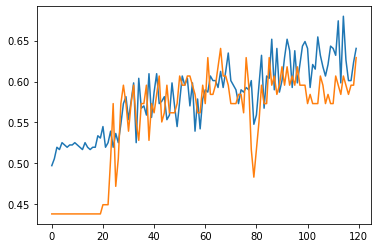

In [17]:
# plot accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

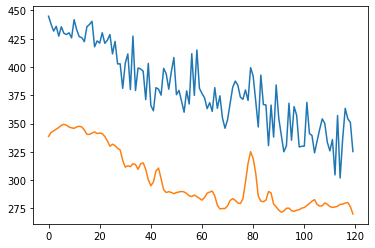

In [18]:
# plot losses
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [19]:
predicted_values_for_X_train = NN_model.predict([X_train_seq_CNN])
predicted_values_for_X_train

14/14 [==============================] - 0s 2ms/step


array([[9.99981999e-01, 1.80438510e-05],
       [9.94913340e-01, 5.08662546e-03],
       [9.99971032e-01, 2.89292529e-05],
       [9.99996066e-01, 3.94839390e-06],
       [5.68827033e-01, 4.31172997e-01],
       [5.53877532e-01, 4.46122408e-01],
       [2.70452187e-03, 9.97295439e-01],
       [8.79033685e-01, 1.20966330e-01],
       [2.32938863e-02, 9.76706088e-01],
       [9.87878621e-01, 1.21213393e-02],
       [9.99922991e-01, 7.69456019e-05],
       [9.11989689e-01, 8.80103260e-02],
       [9.05234575e-01, 9.47654545e-02],
       [1.82662606e-02, 9.81733680e-01],
       [6.24137640e-01, 3.75862330e-01],
       [9.92079198e-01, 7.92083703e-03],
       [7.06779301e-01, 2.93220669e-01],
       [9.28246677e-01, 7.17533231e-02],
       [3.16349208e-01, 6.83650732e-01],
       [3.02124888e-01, 6.97875082e-01],
       [1.46524414e-01, 8.53475571e-01],
       [9.99783337e-01, 2.16674380e-04],
       [7.28474081e-01, 2.71525890e-01],
       [1.44680887e-01, 8.55319083e-01],
       [5.907247

In [20]:
## Curate Test Set
class inputTestObject:
    
    def __init__(self, col):
        self.seq_id = col[0]
        assert len(col[11]) == ACTUAL_LENGTH, len(col[11])
        self.seq = col[11][WINDOW_LENGTH_ORIGINAL-LENGTH_TO_TEST:WINDOW_LENGTH_ORIGINAL+gRNA_LENGTH+LENGTH_TO_TEST]
        self.seq_input = np.array([nt_dict[s] for s in self.seq])
        #self.quartile = int(col[2].replace('Q',''))
        #self.guideScore = float(col[3])
        self.quartile = None
        self.guideScore = None
        self.unpairedProb = []
        
    def process_rna_struct(self, struct, buffer):
        struct = struct[36:36+gRNA_LENGTH]
        
        struct = buffer + [struct_dict[s] for s in struct] + buffer
        self.rna_struct = np.array(struct)
        # print (len(struct), self.rna_struct)

file_test = 'adjusted_raw_data.test.csv'
seq_dict_test = {}
with open(file_test, 'r') as f:
    next(f)
    for line in f:
        col = line.strip('\n').split(',')
        seq_id = col[0]
        seq_dict_test[seq_id] = inputTestObject(col)
        seq_dict_test[seq_id].quartile = int(col[10].replace('Q',''))
        seq_dict_test[seq_id].guideScore = float(col[9])

file3 = "UnpairedProbability.50.txt"
buffer = [0 for _ in range(LENGTH_TO_TEST)]
with open(file3, 'r') as f:
    next(f)
    for c, line in enumerate(f):
        seq_id = col[0]
        col = line.strip('\n').split(',') 
        #print(seq_id, seq_id in seq_dict_test.keys())
        if not seq_id in seq_dict_test.keys(): continue
        
        probs = buffer + [float(i) for i in col[1:]] + buffer
        #print (c, seq_id, probs)
        seq_dict_test[seq_id].unpairedProb = np.array(probs)
        
file_seq = 'RNAfold.results.all.csv'
with open(file_seq, 'r') as f:
    next(f)
    for line in f:
        col = line.strip('\n').split('\t')
        seq_id = col[0]
        
        if seq_id not in seq_dict_test.keys(): continue
        rna_struct = col[4]
        seq_dict_test[seq_id].process_rna_struct(rna_struct, buffer)
        
seq   = []
score = []
quart = []

for k,v in seq_dict_test.items():
    assert len(v.seq) == len(v.unpairedProb), (k, len(v.seq), len(v.unpairedProb), len(v.rna_struct)) 
    seq.append([v.seq_input, v.unpairedProb, v.rna_struct])
    score.append(v.guideScore)
    quart.append(v.quartile)
    
target_data = np.array(score)
quart_data_test  = np.array(quart)
X_test_arr_seq = np.array(seq)
X_test_seq_seq = np.reshape(X_test_arr_seq, (len(X_test_arr_seq), INPUT_LENGTH, 3, 1)) 

In [21]:


NN_model.load_weights('training_models/ea44f9bc-a0f4-4933-98df-d3c8d5fb111c-cp-0079.ckpt')
training_predictions = NN_model.predict([X_train_seq_CNN])
predictions = NN_model.predict(X_test_seq_seq)


4/4 [==============================] - 0s 2ms/step


In [22]:
from sklearn.metrics import confusion_matrix
predicted_labels = np.argmax(predictions, axis=1)
poor_count = 0
for c, (i,j) in enumerate(zip(predicted_labels, quart_data_test)):
    poor = 'Poor' if i == 1 and j == 0 else 'Okay'
    if poor == 'Poor':
        poor_count += 1
    print (c, "Pred", i, "True", j, i==j, poor)
    

cm = confusion_matrix(quart_data_test,predicted_labels)
print (cm)

0 Pred 1 True 0 False Poor
1 Pred 0 True 0 True Okay
2 Pred 0 True 1 False Okay
3 Pred 1 True 1 True Okay
4 Pred 1 True 1 True Okay
5 Pred 1 True 1 True Okay
6 Pred 0 True 1 False Okay
7 Pred 1 True 1 True Okay
8 Pred 0 True 0 True Okay
9 Pred 1 True 1 True Okay
10 Pred 0 True 0 True Okay
11 Pred 0 True 0 True Okay
12 Pred 0 True 0 True Okay
13 Pred 0 True 0 True Okay
14 Pred 1 True 1 True Okay
15 Pred 1 True 1 True Okay
16 Pred 1 True 1 True Okay
17 Pred 1 True 1 True Okay
18 Pred 0 True 1 False Okay
19 Pred 1 True 1 True Okay
20 Pred 1 True 1 True Okay
21 Pred 0 True 1 False Okay
22 Pred 0 True 1 False Okay
23 Pred 1 True 1 True Okay
24 Pred 0 True 1 False Okay
25 Pred 1 True 0 False Poor
26 Pred 0 True 0 True Okay
27 Pred 0 True 0 True Okay
28 Pred 0 True 0 True Okay
29 Pred 0 True 0 True Okay
30 Pred 1 True 1 True Okay
31 Pred 1 True 1 True Okay
32 Pred 0 True 1 False Okay
33 Pred 0 True 0 True Okay
34 Pred 0 True 0 True Okay
35 Pred 0 True 1 False Okay
36 Pred 0 True 0 True Okay
3

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(quart_data_test,predicted_labels)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(quart_data_test,predicted_labels)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(quart_data_test,predicted_labels)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(quart_data_test,predicted_labels)
print('F1 score: %f' % f1)

Accuracy: 0.609524
Precision: 0.577778
Recall: 0.541667
F1 score: 0.559140


In [24]:

predicted_labels = np.argmax(training_predictions, axis=1)

poor_count = 0
for c, (i,j) in enumerate(zip(predicted_labels, quart_data)):
    poor = 'Poor' if i == 1 and j == 0 else 'Okay'
    if poor == 'Poor':
        poor_count += 1
    print (c, "Pred", i, "True", j, i==j, poor)
    

cm = confusion_matrix(quart_data,predicted_labels)
print(cm)

0 Pred 1 True 0 False Poor
1 Pred 0 True 0 True Okay
2 Pred 0 True 0 True Okay
3 Pred 1 True 0 False Poor
4 Pred 0 True 0 True Okay
5 Pred 0 True 0 True Okay
6 Pred 1 True 0 False Poor
7 Pred 1 True 0 False Poor
8 Pred 1 True 0 False Poor
9 Pred 1 True 1 True Okay
10 Pred 1 True 0 False Poor
11 Pred 0 True 0 True Okay
12 Pred 0 True 0 True Okay
13 Pred 1 True 1 True Okay
14 Pred 1 True 1 True Okay
15 Pred 1 True 0 False Poor
16 Pred 1 True 1 True Okay
17 Pred 1 True 0 False Poor
18 Pred 1 True 1 True Okay
19 Pred 1 True 1 True Okay
20 Pred 0 True 0 True Okay
21 Pred 0 True 0 True Okay
22 Pred 0 True 1 False Okay
23 Pred 1 True 0 False Poor
24 Pred 0 True 1 False Okay
25 Pred 1 True 1 True Okay
26 Pred 1 True 1 True Okay
27 Pred 1 True 1 True Okay
28 Pred 1 True 0 False Poor
29 Pred 1 True 1 True Okay
30 Pred 1 True 1 True Okay
31 Pred 1 True 1 True Okay
32 Pred 1 True 0 False Poor
33 Pred 1 True 1 True Okay
34 Pred 0 True 0 True Okay
35 Pred 1 True 1 True Okay
36 Pred 1 True 1 True Oka

384 Pred 1 True 0 False Poor
385 Pred 0 True 1 False Okay
386 Pred 1 True 1 True Okay
387 Pred 1 True 1 True Okay
388 Pred 0 True 1 False Okay
389 Pred 1 True 1 True Okay
390 Pred 1 True 1 True Okay
391 Pred 0 True 1 False Okay
392 Pred 1 True 0 False Poor
393 Pred 1 True 0 False Poor
394 Pred 1 True 0 False Poor
395 Pred 1 True 1 True Okay
396 Pred 0 True 0 True Okay
397 Pred 1 True 0 False Poor
398 Pred 1 True 0 False Poor
399 Pred 0 True 0 True Okay
400 Pred 1 True 0 False Poor
401 Pred 1 True 1 True Okay
402 Pred 0 True 1 False Okay
403 Pred 1 True 1 True Okay
404 Pred 0 True 0 True Okay
405 Pred 0 True 1 False Okay
406 Pred 1 True 1 True Okay
407 Pred 0 True 0 True Okay
408 Pred 1 True 0 False Poor
409 Pred 1 True 0 False Poor
410 Pred 1 True 1 True Okay
411 Pred 0 True 0 True Okay
412 Pred 0 True 0 True Okay
413 Pred 0 True 0 True Okay
414 Pred 0 True 1 False Okay
415 Pred 0 True 0 True Okay
416 Pred 0 True 0 True Okay
417 Pred 0 True 0 True Okay
418 Pred 1 True 0 False Poor
419 

In [25]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(quart_data,predicted_labels)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(quart_data,predicted_labels)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(quart_data,predicted_labels)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(quart_data,predicted_labels)
print('F1 score: %f' % f1)

Accuracy: 0.653933
Precision: 0.669856
Recall: 0.622222
F1 score: 0.645161
